In [1]:
import polars as pl 
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import MultiComparison
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
endpoint_types = ["toxcast_cellbased", "toxcast_cellfree", "toxcast_cytotox", "axiom"]

pred_df = []
for et in endpoint_types:
    preds = pl.read_parquet(f"./compiled_results/compiled_{et}_metrics.parquet")
    preds = preds.with_columns(
        (pl.col("Metadata_Count_0") + pl.col("Metadata_Count_1")).alias("Total_Compounds"),
        pl.lit(et).alias("Endpoint_type")
    )
    pred_df.append(preds)

pred_df = pl.concat(pred_df, how="vertical")
pred_df = pred_df.with_columns(
    pl.when(pl.col("Endpoint_type") == "axiom").then(pl.lit("axiom_cytotox")).otherwise(pl.col("Endpoint_type")).alias("Endpoint_type")
)

pred_df = (pred_df
            .filter(pl.col("Model_type") == "Actual")
            .filter(pl.col("Feat_type") == "dino")
            .filter(pl.col("Metadata_AggType") == "all"))

In [3]:
cell_df = pred_df.filter(pl.col("Endpoint_type") == "toxcast_cellbased")

cell_df = cell_df.with_columns(
    pl.when(pl.col("Metadata_Label").str.contains("_GR_")).then(pl.lit("ER")).otherwise(pl.lit("Other")).alias("ER")
)

ar_assays = cell_df.filter(pl.col("ER") == "ER").select("Metadata_Label").to_series().to_list()
ar_df = cell_df.filter(pl.col("Metadata_Label").is_in(ar_assays))
ar_assays

['TOX21_GR_BLA_Antagonist_ratio', 'TOX21_GR_BLA_Agonist_ratio']

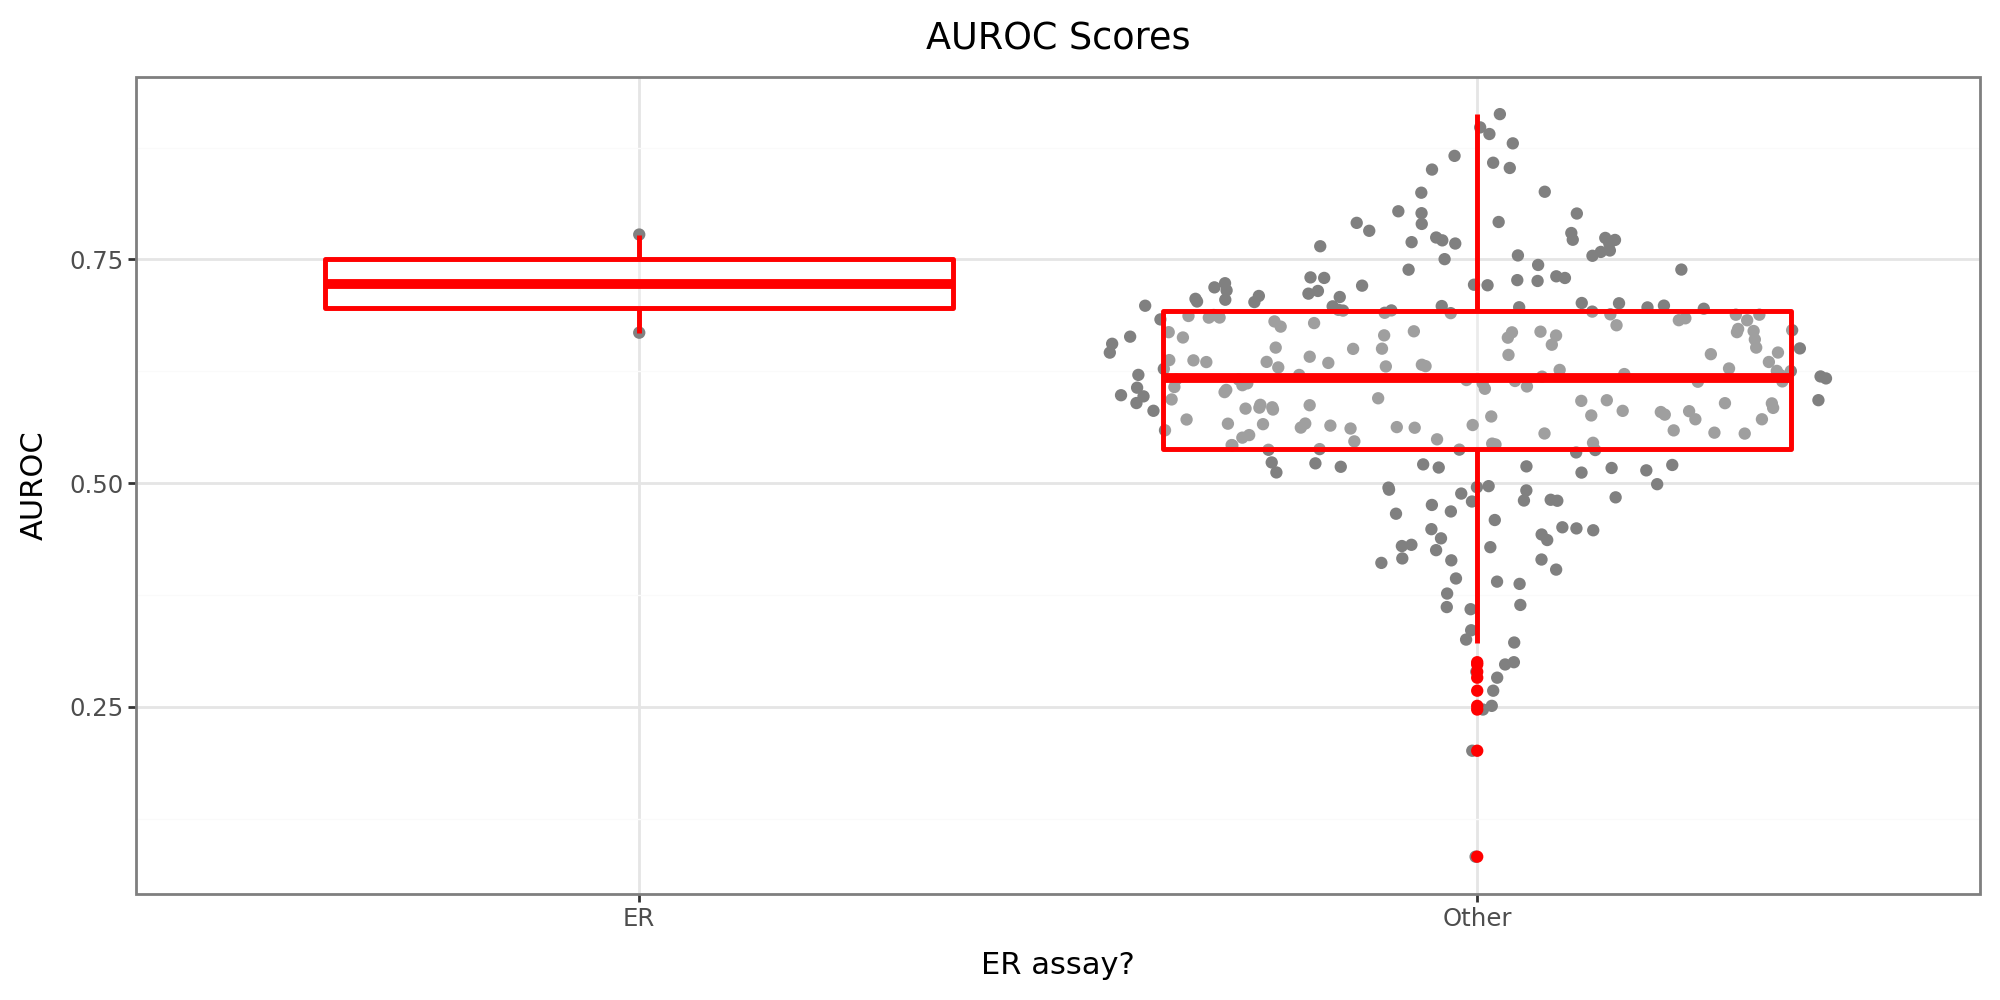

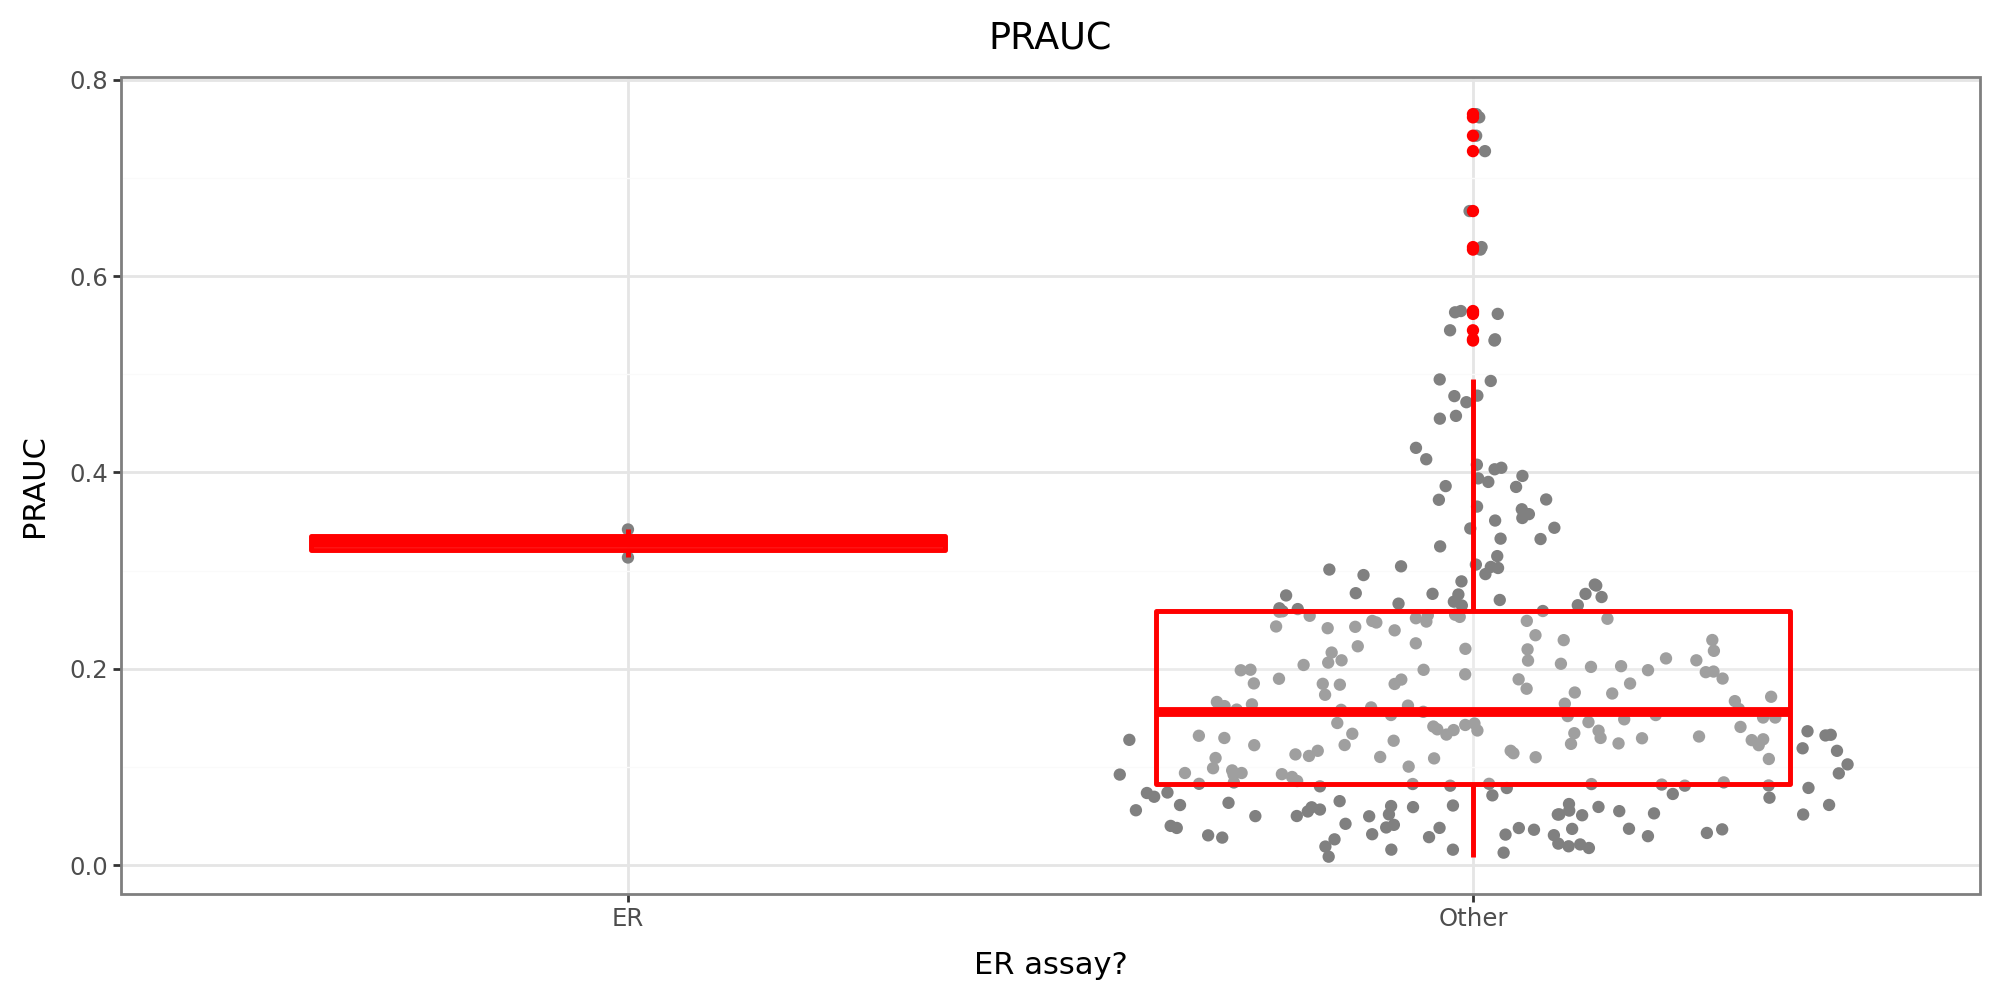

In [23]:
from plotnine import ggplot, aes, geom_sina, geom_boxplot, labs, theme_bw, position_dodge, facet_wrap
import plotnine as pn

pn.options.figure_size = (10, 5)

plot = (
    ggplot(cell_df, aes(x='ER', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='AUROC Scores', x='ER assay?', y='AUROC') 
    + theme_bw()
)
plot.show()

plot = (
    ggplot(cell_df, aes(x='ER', y='PRAUC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='PRAUC', x='ER assay?', y='PRAUC') 
    + theme_bw()
)
plot.show()

## Examine AR annotations

In [4]:
labels = pl.read_parquet("../1_snakemake/inputs/annotations/toxcast_cellbased_binary.parquet").select(
    ["OASIS_ID"] + ar_assays
)

oasis_ids = pl.read_parquet("../1_snakemake/outputs/cellprofiler/mad_featselect/classifier_results/toxcast_cellbased_binary_predictions.parquet").select("Metadata_OASIS_ID").to_series().unique().to_list()

labels = labels.filter(pl.col("OASIS_ID").is_in(oasis_ids))

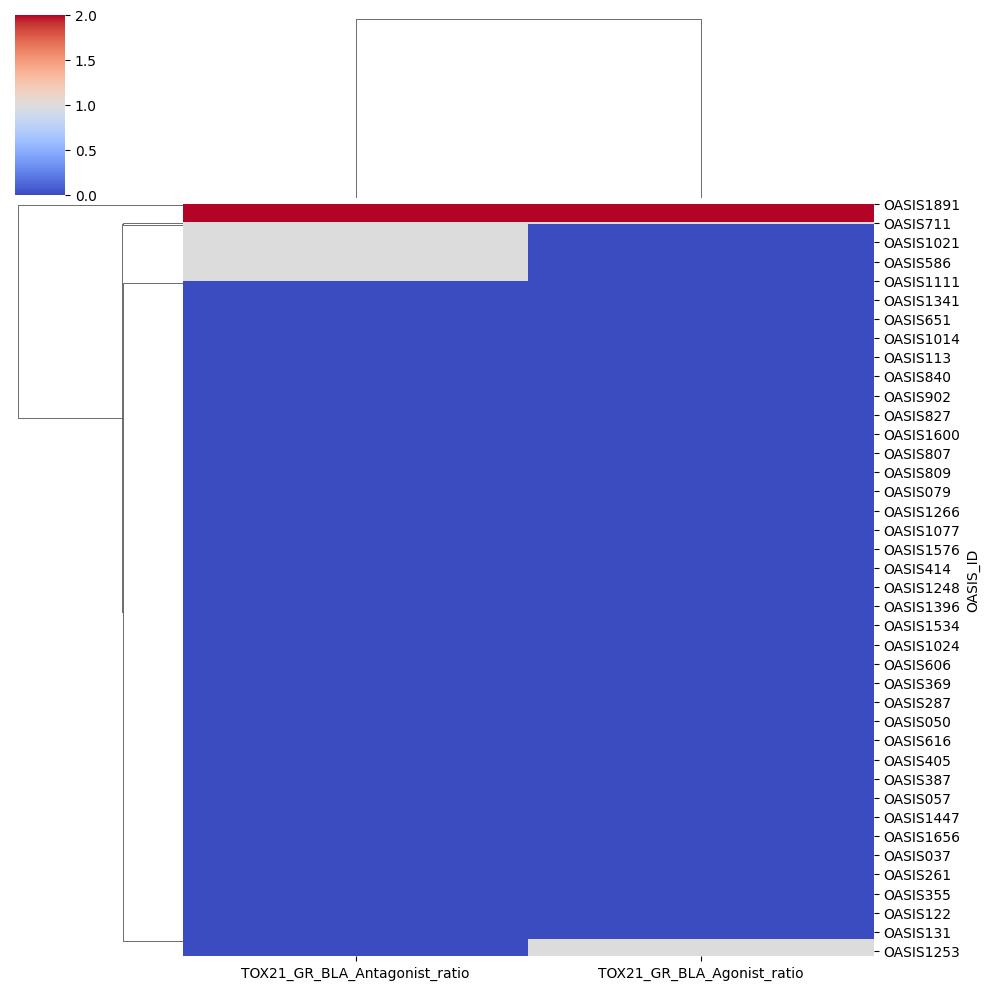

In [25]:
df = labels.to_pandas().set_index("OASIS_ID")
df = df.fillna(2)

cmap = sns.color_palette("coolwarm", as_cmap=True)

sns.clustermap(
    df,
    cmap=cmap,
    row_cluster=True,
    col_cluster=True,
    vmin=0, vmax=2
)
plt.show()

In [5]:
# best agonist: TOX21_AR_LUC_MDAKB2_Agonist_3uM_Nilutamide
# best antagonist: TOX21_AR_LUC_MDAKB2_Antagonist_10nM_R1881

ar_antag = labels.filter(pl.col("TOX21_GR_BLA_Antagonist_ratio") == 1).select("OASIS_ID").to_series().to_list()
ar_ag = labels.filter(pl.col("TOX21_GR_BLA_Agonist_ratio") == 1).select("OASIS_ID").to_series().to_list()

ar_ids = list(set(ar_ag + ar_antag))

[i for i in ar_ag if i in ar_antag]

['OASIS492', 'OASIS711']

In [6]:
ar_1 = labels.filter((pl.col("TOX21_GR_BLA_Agonist_ratio") == 1) | (pl.col("TOX21_GR_BLA_Agonist_ratio") == 0)).select("OASIS_ID").to_series().to_list()
ar_2 = labels.filter((pl.col("TOX21_GR_BLA_Antagonist_ratio") == 1) | (pl.col("TOX21_GR_BLA_Antagonist_ratio") == 0)).select("OASIS_ID").to_series().to_list()

all_ar = list(set(ar_1 + ar_2))

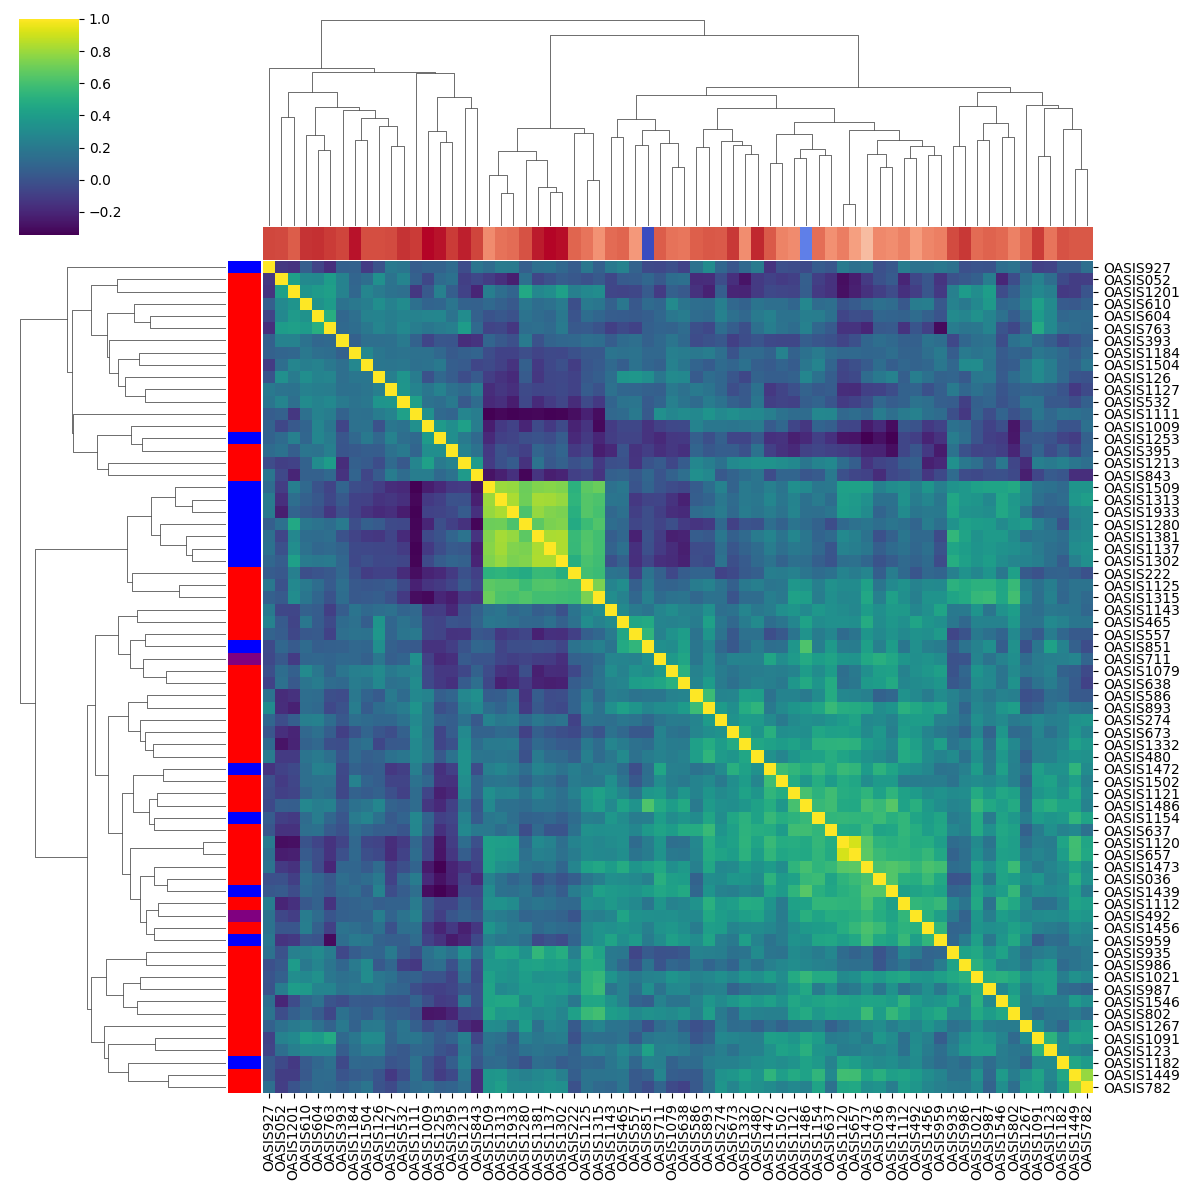

In [7]:
# all
agg_prof = pl.read_parquet("/dgx1nas1/storage/data/jess/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/dino/mad_featselect/aggregated_profiles/agg.parquet")
agg_prof = agg_prof.filter(pl.col("Metadata_AggType") == "all").drop(["Metadata_AggType"]).filter(
    pl.col("Metadata_OASIS_ID").is_in(ar_ids)
)

agg_prof = agg_prof.with_columns(
    pl.when(pl.col("Metadata_OASIS_ID").is_in(ar_ag) & pl.col("Metadata_OASIS_ID").is_in(ar_antag))
      .then(pl.lit("Both"))
      .when(pl.col("Metadata_OASIS_ID").is_in(ar_ag))
      .then(pl.lit("Agonist"))
      .when(pl.col("Metadata_OASIS_ID").is_in(ar_antag))
      .then(pl.lit("Antagonist"))
      .alias("Metadata_AR_type")
)

from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm

cosine_distance_matrix = squareform(pdist(agg_prof.drop(["Metadata_OASIS_ID", "Metadata_AR_type", "Cell_Count"]), metric='cosine')) 
cosine_similarity_matrix = 1 - cosine_distance_matrix

metadata = agg_prof.select(["Metadata_OASIS_ID", "Metadata_AR_type", "Cell_Count"]).to_pandas()
norm = Normalize(vmin=metadata["Cell_Count"].min(), vmax=metadata["Cell_Count"].max())

cell_count_colors = cm.coolwarm(norm(metadata["Cell_Count"]))

ar_type_color_map = {"Agonist": "blue", "Antagonist": "red", "Both": "purple"}
row_col_colors = metadata["Metadata_AR_type"].map(ar_type_color_map).to_numpy()

g = sns.clustermap(
    cosine_similarity_matrix,
    cmap='viridis',
    xticklabels=metadata["Metadata_OASIS_ID"],
    yticklabels=metadata["Metadata_OASIS_ID"],
    figsize=(12, 12),
    row_colors=row_col_colors,
    col_colors=cell_count_colors
)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.show()

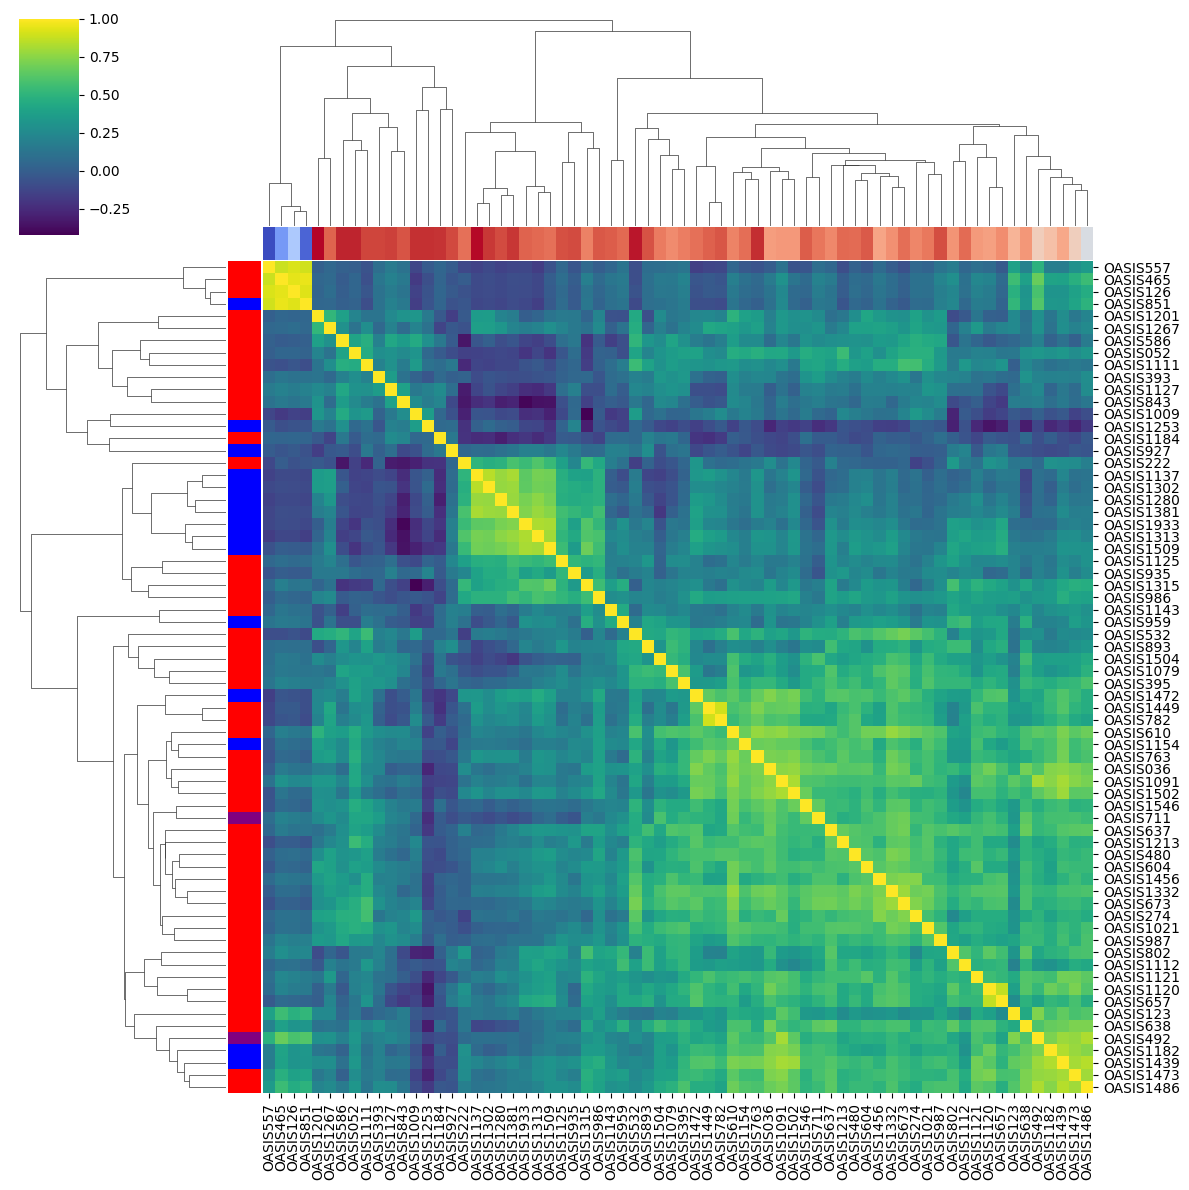

In [8]:
# allpod
agg_prof = pl.read_parquet("/dgx1nas1/storage/data/jess/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/dino/mad_featselect/aggregated_profiles/agg.parquet")
agg_prof = agg_prof.filter(pl.col("Metadata_AggType") == "allpod").drop(["Metadata_AggType"]).filter(
    pl.col("Metadata_OASIS_ID").is_in(ar_ids)
)

agg_prof = agg_prof.with_columns(
    pl.when(pl.col("Metadata_OASIS_ID").is_in(ar_ag) & pl.col("Metadata_OASIS_ID").is_in(ar_antag))
      .then(pl.lit("Both"))
      .when(pl.col("Metadata_OASIS_ID").is_in(ar_ag))
      .then(pl.lit("Agonist"))
      .when(pl.col("Metadata_OASIS_ID").is_in(ar_antag))
      .then(pl.lit("Antagonist"))
      .alias("Metadata_AR_type")
)

from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm

cosine_distance_matrix = squareform(pdist(agg_prof.drop(["Metadata_OASIS_ID", "Metadata_AR_type", "Cell_Count"]), metric='cosine')) 
cosine_similarity_matrix = 1 - cosine_distance_matrix

metadata = agg_prof.select(["Metadata_OASIS_ID", "Metadata_AR_type", "Cell_Count"]).to_pandas()
norm = Normalize(vmin=metadata["Cell_Count"].min(), vmax=metadata["Cell_Count"].max())

cell_count_colors = cm.coolwarm(norm(metadata["Cell_Count"]))

ar_type_color_map = {"Agonist": "blue", "Antagonist": "red", "Both": "purple"}
row_col_colors = metadata["Metadata_AR_type"].map(ar_type_color_map).to_numpy()

g = sns.clustermap(
    cosine_similarity_matrix,
    cmap='viridis',
    xticklabels=metadata["Metadata_OASIS_ID"],
    yticklabels=metadata["Metadata_OASIS_ID"],
    figsize=(12, 12),
    row_colors=row_col_colors,
    col_colors=cell_count_colors
)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.show()

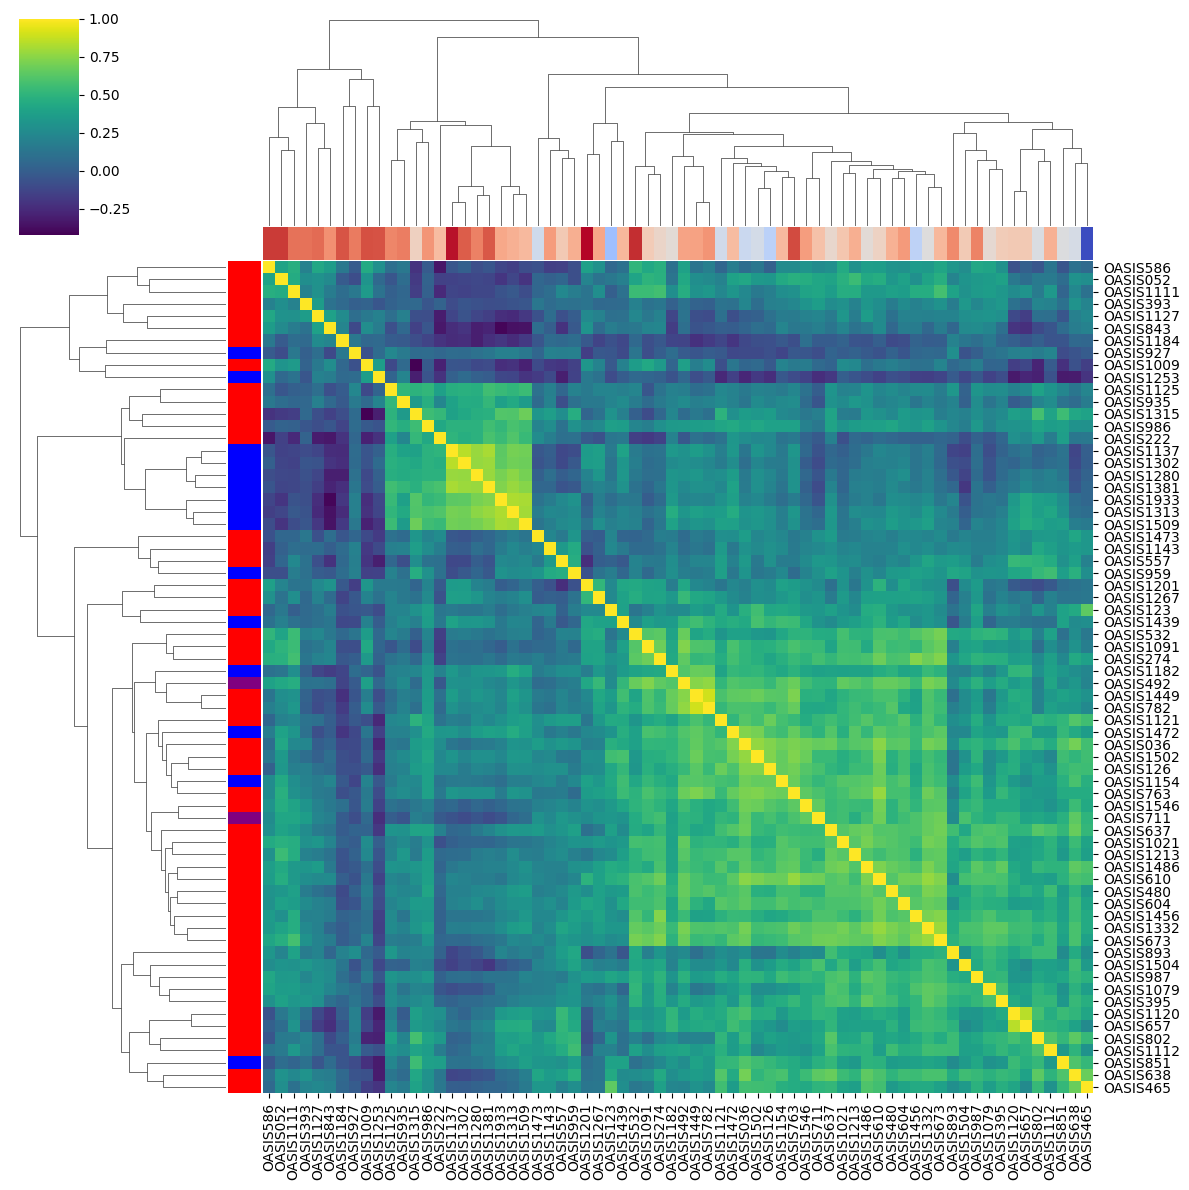

In [9]:
# allpodcc
agg_prof = pl.read_parquet("/dgx1nas1/storage/data/jess/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/dino/mad_featselect/aggregated_profiles/agg.parquet")
agg_prof = agg_prof.filter(pl.col("Metadata_AggType") == "allpodcc").drop(["Metadata_AggType"]).filter(
    pl.col("Metadata_OASIS_ID").is_in(ar_ids)
)

agg_prof = agg_prof.with_columns(
    pl.when(pl.col("Metadata_OASIS_ID").is_in(ar_ag) & pl.col("Metadata_OASIS_ID").is_in(ar_antag))
      .then(pl.lit("Both"))
      .when(pl.col("Metadata_OASIS_ID").is_in(ar_ag))
      .then(pl.lit("Agonist"))
      .when(pl.col("Metadata_OASIS_ID").is_in(ar_antag))
      .then(pl.lit("Antagonist"))
      .alias("Metadata_AR_type")
)

from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm

cosine_distance_matrix = squareform(pdist(agg_prof.drop(["Metadata_OASIS_ID", "Metadata_AR_type", "Cell_Count"]), metric='cosine')) 
cosine_similarity_matrix = 1 - cosine_distance_matrix

metadata = agg_prof.select(["Metadata_OASIS_ID", "Metadata_AR_type", "Cell_Count"]).to_pandas()
norm = Normalize(vmin=metadata["Cell_Count"].min(), vmax=metadata["Cell_Count"].max())

cell_count_colors = cm.coolwarm(norm(metadata["Cell_Count"]))

ar_type_color_map = {"Agonist": "blue", "Antagonist": "red", "Both": "purple"}
row_col_colors = metadata["Metadata_AR_type"].map(ar_type_color_map).to_numpy()

g = sns.clustermap(
    cosine_similarity_matrix,
    cmap='viridis',
    xticklabels=metadata["Metadata_OASIS_ID"],
    yticklabels=metadata["Metadata_OASIS_ID"],
    figsize=(12, 12),
    row_colors=row_col_colors,
    col_colors=cell_count_colors
)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.show()

In [ ]:
ids = ["OASIS222", "OASIS986", "OASIS1315", "OASIS935", "OASIS1125"]

oasis = pl.read_csv("/dgx1nas1/storage/data/jess/repos/2024_09_09_Axiom_OASIS/1_snakemake/inputs/annotations/seal_input/v5_oasis_03Sept2024_simple.csv")

oasis_antag = oasis.filter(pl.col("OASIS_ID").is_in(ids))

oasis_antag.select("PREFERRED_NAME").to_series().to_list()

# These compounds are intersting because they are quite similar to the cluster of strong GR agonists.
# All except ingliforib are steroidal compounds, especially androgenic. 
# Ingliforib inhibits glycogen phosphorylase (lowers blood sugar) and protects against cardiotoxicity 

['Tibolone',
 'Nandrolone decanoate',
 'Ingliforib',
 'Levonorgestrel',
 'Dehydroepiandrosterone']

In [13]:
ids = [
    "OASIS532", "OASIS1091", "OASIS274", "OASIS1182", "OASIS492", "OASIS1449", "OASIS782", "OASIS1121", "OASIS1472", 
    "OASIS036", "OASIS1502", "OASIS126", "OASIS1154", "OASIS763", "OASIS1546", "OASIS711", "OASIS637", "OASIS1021", 
    "OASIS1213", "OASIS1486", "OASIS610", "OASIS480", "OASIS604", "OASIS1456", "OASIS1332", "OASIS673"
]

oasis_antag = oasis.filter(pl.col("OASIS_ID").is_in(ids))

oasis_antag.select("PREFERRED_NAME").to_series().to_list()

['Norethindrone',
 'Alfacalcidol',
 'Nifedipine',
 'Triamterene',
 'Rifapentine',
 'Diniconazole',
 'SSR69071',
 'Fluvastatin',
 'Atorvastatin',
 '17beta-Estradiol',
 'Erlotinib',
 'Difenoconazole',
 'Dofetilide',
 'Calcitriol',
 'Dydrogesterone',
 'Nicardipine',
 'Nisoldipine',
 'Deferasirox',
 'Sofalcone',
 'Nelivaptan',
 'Norethindrone acetate',
 '5-Azacytidine',
 'Cilnidipine',
 'Clotrimazole',
 'Penconazole',
 'Romidepsin']

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


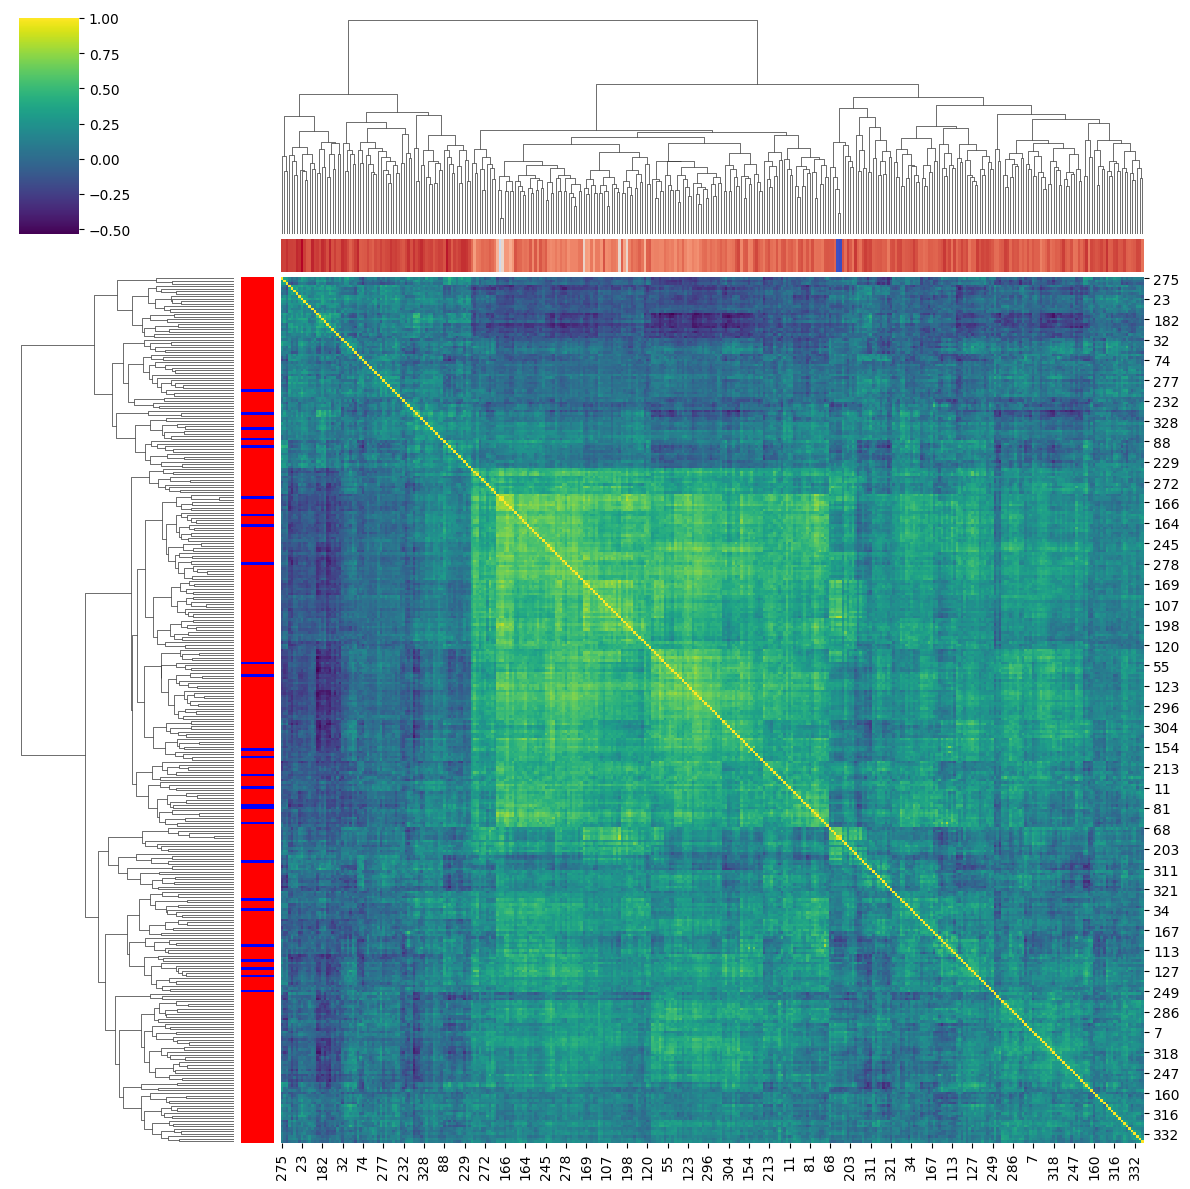

In [18]:
agg_prof = pl.read_parquet("/dgx1nas1/storage/data/jess/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/dino/mad_featselect/aggregated_profiles/agg.parquet")
agg_prof = agg_prof.filter(pl.col("Metadata_AggType") == "all").drop(["Metadata_AggType"])

agg_prof = agg_prof.filter(
    (pl.col("Metadata_OASIS_ID").is_in(ids)) | (~pl.col("Metadata_OASIS_ID").is_in(all_ar))
)

agg_prof = agg_prof.with_columns(
    pl.when(pl.col("Metadata_OASIS_ID").is_in(ids))
      .then(pl.lit("Glucocorticoid"))
      .otherwise(pl.lit("Other"))
      .alias("Metadata_GR_type")
)

from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm

cosine_distance_matrix = squareform(pdist(agg_prof.drop(["Metadata_OASIS_ID", "Metadata_GR_type", "Cell_Count"]), metric='cosine')) 
cosine_similarity_matrix = 1 - cosine_distance_matrix

metadata = agg_prof.select(["Metadata_OASIS_ID", "Metadata_GR_type", "Cell_Count"]).to_pandas()
norm = Normalize(vmin=metadata["Cell_Count"].min(), vmax=metadata["Cell_Count"].max())

cell_count_colors = cm.coolwarm(norm(metadata["Cell_Count"]))

ar_type_color_map = {"Glucocorticoid": "blue", "Other": "red"}
row_col_colors = metadata["Metadata_GR_type"].map(ar_type_color_map).to_numpy()

g = sns.clustermap(
    cosine_similarity_matrix,
    cmap='viridis',
    #xticklabels=metadata["Metadata_OASIS_ID"],
    #yticklabels=metadata["Metadata_OASIS_ID"],
    figsize=(12, 12),
    row_colors=row_col_colors,
    col_colors=cell_count_colors
)
#g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90)
#g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.show()